# Blight fines dataset

About the data: https://midas.umich.edu/wp-content/uploads/sites/3/2017/09/understanding-blight-ticket.pdf

## Goal

The goal of our work is to estimate compliance based of of historical data

## Data init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import re

In [2]:
# Do not touch me
df_fines = pd.read_csv("fines.csv", sep=',',skiprows=0,skipfooter=1, na_values=None,engine='python')
df_latlons = pd.read_csv("latlons.csv", sep=',', skiprows=0, skipfooter=1, na_values=None,engine='python')
df_addresses = pd.read_csv("addresses.csv", sep=',', skiprows=0, na_values=None,engine='python')

In [3]:
len(df_fines.index)

62492

## Data Cleaning

We assumed these enumerations:

| **payment status** | value assigned |
| ------------------ | -------------- |
| NO PAYMENT APPLIED      |         0 |
| PARTIAL PAYMENT APPLIED |         1 |
| PAID IN FULL            |         2 |

<br>

| **disposition** | value assigned |
| --------------- | -------------- |
| Not responsible by Dismissal      | Not responsible |
| Not responsible by City Dismissal | Not responsible |
| Not responsible by Determination  | Not responsible |
| Responsible by Default            | Responsible  |
| Responsible by Determination      | Responsible  |
| Responsible by Admission          | Responsible  |
| PENDING JUDGMENT                  | _omitted_ |
| SET-ASIDE (PENDING JUDGMENT)      | _omitted_ |

<br>

We have also removed all fines where the subject corrected the violation before his hearing, eg. when the case was dismissed.

We have changed compliancy 0/1 values to boolean 

In [4]:
df_fines['payment_status'] = df_fines['payment_status'].map(
    lambda x: 0 if x == 'NO PAYMENT APPLIED'
              else 1 if x == 'PARTIAL PAYMENT APPLIED'
              else 2
    )

In [5]:
not_responsible_tags = r'Not responsible by Dismissal\
                        |Not responsible by City Dismissal\
                        |Not responsible by Determination'
responsible_tags = r'Responsible by Default\
                    |Responsible by Determination\
                    |Responsible by Admission'
omitted_tags = (r'PENDING JUDGMENT|SET-ASIDE \(PENDING JUDGMENT\)')

# Filter out fines that were not resolved
df_fines = df_fines[df_fines.disposition.str.contains(omitted_tags) == False]

# Change labels to boolean vals
df_fines['disposition'] = df_fines['disposition'].map(
    lambda x:
        "Not responsible" if x in not_responsible_tags
        else "Responsible")

In [6]:
# Remove fines that were dismissed
df_fines = df_fines[df_fines['disposition'] == "Responsible"]

In [7]:
# Change 0/1 compliance to boolean


In [8]:
df_fines.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')

In [9]:
columns = ['violation_code','violation_description','disposition']
for col in df_fines.columns:
    df_fines[col] = df_fines[col].astype('category')
    

In [45]:
df_fines['mailing_address_str_name'] = df_fines['mailing_address_str_name'].astype(str)
df_fines['violation_street_name'] = df_fines['violation_street_name'].astype(str)

In [10]:
len(df_fines.index)

42023

## Creating the owner column

In [44]:
df_fines['owner'] = np.where(df_fines['mailing_address_str_name'].astype(str).str.upper() == df_fines['violation_street_name'].astype(str).str.upper(), 1,0)
#df_fines['owner'] = np.where(df_fines['mailing_address_str_number'].astype(float) == df_fines['violation_street_number'].astype(float),1,0)

In [42]:
#df_fines['violation_street_name'].unique()
#df_fines['mailing_address_str_name'].unique()
df_fines[df_fines['owner'] == 1]

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,owner
12,18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",9100,VAN DYKE,NaN,91.0,Van Dyke,Detroit,...,855.0,0.0,855.0,NaN,0,IN COLLECTION,NaN,non-compliant by no payment,0.0,1
13,18741,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Hardaway, Kevin",20024,SCHAEFER,NaN,224.0,Schaefer,Detroit,...,855.0,0.0,855.0,NaN,0,IN COLLECTION,NaN,non-compliant by no payment,0.0,1
14,18978,"Buildings, Safety Engineering & Env Department","Williams, Darrin","TLC Hand Car Wash, a/k/a",9425,VAN DYKE,NaN,9425.0,Van Dyke,Detroit,...,855.0,0.0,855.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0,1
18,18746,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Klenk, Dean",14715,KLENK,NaN,14715.0,Klenk,Detroit,...,140.0,130.0,10.0,3/18/2005 0:00,2,NaN,NaN,compliant by late payment within 1 month,1.0,1
19,18744,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Kuhn, Dean",14715,KLENK,NaN,141715.0,Klenk,Detroit,...,140.0,130.0,10.0,3/18/2005 0:00,2,NaN,NaN,compliant by late payment within 1 month,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62455,87205,Department of Public Works,"Bell, Maydell","MALKI, SHAMOUN",415,FERNHILL,NaN,415.0,FERNHILL,DETROIT,...,250.0,0.0,250.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0,1
62464,87110,Department of Public Works,"Lewis, Velinda","Agnitch, James J.",19692,OMIRA,NaN,19692.0,Omira,Detroit,...,130.0,120.0,10.0,9/11/2006 0:00,1,NaN,NaN,non-compliant by no payment,0.0,1
62468,86471,Department of Public Works,"Stanford, Elton","BELL, SHARON",20130,KEATING,NaN,213.0,KEATING,DETROIT,...,250.0,0.0,250.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0,1
62474,87478,Department of Public Works,"Brooks, Eric","Dinverno, Enrico",610,COLTON,NaN,61.0,Colton,Detroit,...,1130.0,0.0,1130.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0,1


## Combine the data

In [11]:
df_joint = pd.merge(df_addresses, df_latlons,
                    how='inner', on='address')
df_joint = pd.merge(df_fines, df_joint,
                    how='inner', on='ticket_id')

In [12]:
len(df_fines.index)

42023

## Data exploration

### Header of the DataFrame

In [13]:
df_fines.head(5)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0,305.0,0.0,305.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0,855.0,780.0,75.0,6/2/2005 0:00,2,NaN,NaN,compliant by late payment within 1 month,1.0
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,0,305.0,0.0,305.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0
6,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,0,855.0,0.0,855.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0
7,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,0,140.0,0.0,140.0,NaN,0,NaN,NaN,non-compliant by no payment,0.0


In [14]:
df_fines.iloc[3]

ticket_id                                                              18738
agency_name                   Buildings, Safety Engineering & Env Department
inspector_name                                              Williams, Darrin
violator_name                           Deerwood Development Group Inc, Deer
violation_street_number                                                 8027
violation_street_name                                              BRENTWOOD
violation_zip_code                                                       NaN
mailing_address_str_number                                             476.0
mailing_address_str_name                                            Garfield
city                                                                 Clinton
state                                                                     MI
zip_code                                                               48038
non_us_str_code                                                          NaN

In [15]:
df_fines.corr(method='pearson')

ValueError: could not convert string to float: 'Failure of owner to obtain certificate of compliance'

### How many fines there are?

In [ ]:
len(df_fines.index)

62492

### Count numbers of fines by `violator_name` 

In [ ]:
df_fine_counter=df_fines['violator_name'].value_counts().to_dict()
df_fines.head(10)
df_fine_counter

{'INVESTMENT, ACORN': 340,
 'INVESTMENT CO., ACORN': 202,
 'SNOW, GEORGE': 78,
 'Investment, Acorn': 74,
 'SHIFMAN, ALLEN': 65,
 'MILLER, JOHN': 64,
 'ACORN INVESTMENT, *': 52,
 'SANTARELLI, MARCO': 51,
 'MANAGEMENT CO., WINGATE': 47,
 'BANK, WELLS FARGO': 47,
 'KRAMER, KEITH': 45,
 'LDHA, BARCLAY': 42,
 'FRIEDMAN, SINSILVER': 41,
 'NEW YORK, BANK OF': 37,
 'PACE, MICHAEL': 37,
 'RICHARDSON, JOHN': 34,
 'HUDSON, OTTMAR': 34,
 'STEHLIK, JERRY': 32,
 'ESTATES, EVERGREEN': 31,
 'BUFFINGTON, DERONE': 30,
 'MANAGEMENT, FOREST CITY': 30,
 'BURRELL, RAYMOND': 29,
 'ROSEN, NATHAN': 29,
 'INVESTMENTS, ACORN': 29,
 'FOR DETROIT, NEW VISIONS': 28,
 'WOLFE, KENNETH': 28,
 'VILLAS, GENESIS': 27,
 'GROUP, THE APARTMENT': 27,
 'DETROIT HOUSING COMMISSION, *': 27,
 'APARTMENTS, RYAN COURT': 26,
 'CONSTRUCTION, REX': 26,
 'APARTMENTS, CARLTON': 26,
 'MITCHELL, MARCO L.': 25,
 'DOE, JOHN': 25,
 'BURRELL, HELENE': 25,
 'COMMONS LDHA LP, CHENE PARK': 25,
 'LEONARD, JACK': 25,
 'KING VILLAGE, ALBERTA W.': 

### Counts of most common fine types 

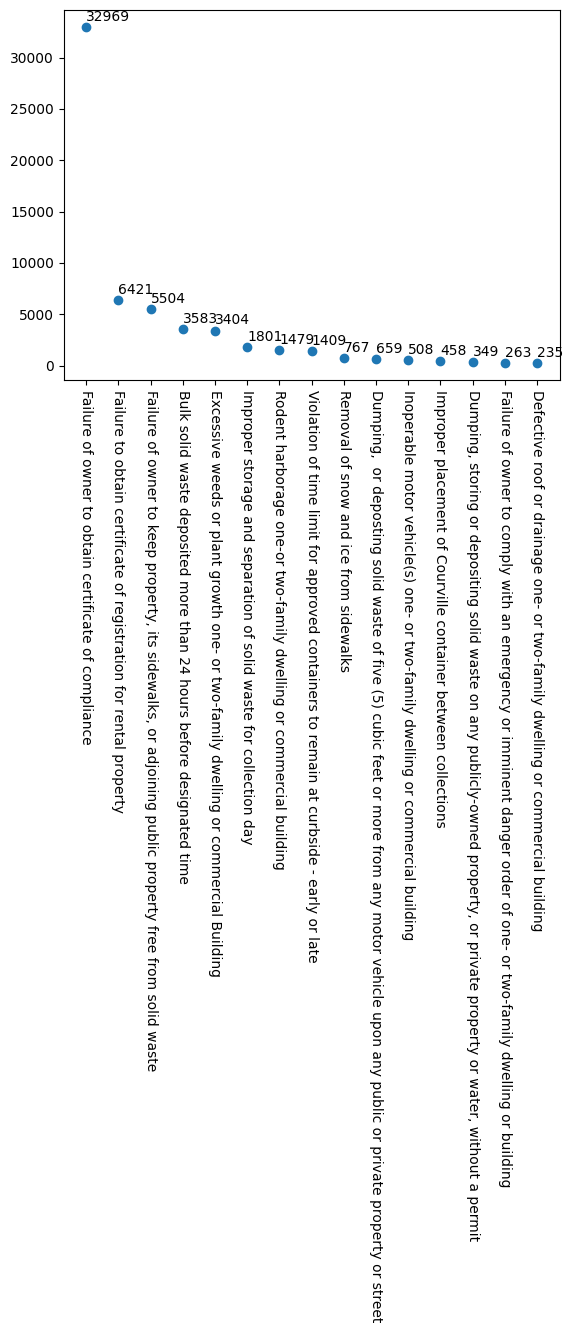

In [ ]:
#Getting the different values and descriptions
numberOfTimes = df_fines['violation_description'].value_counts()
number = pd.DataFrame({'description':numberOfTimes.index,'times':numberOfTimes.values}).head(n=15) #e just want the first 15 because are the most relevant
plt.scatter(number['description'],number['times'])
plt.xticks(number['description'], rotation=-90)
for i, row in number.iterrows():
    plt.text(row['description'], row['times']+600, s= str(row['times']))
plt.show()

### Which streets have most of the fines?

In [ ]:
df_fine_counter_by_street=df_fines['violation_street_name'].value_counts().to_dict()
df_fine_counter_by_street
##len(df_fine_counter_by_street)

{'SEVEN MILE': 1169,
 'MCNICHOLS': 915,
 'LIVERNOIS': 644,
 'EVERGREEN': 607,
 'FENKELL': 441,
 'JOY RD': 426,
 'WARREN': 418,
 'EIGHT MILE': 387,
 'SCHAEFER': 361,
 'GRAND RIVER': 354,
 'PURITAN': 338,
 'PLYMOUTH': 330,
 'FORRER': 323,
 'STOEPEL': 315,
 'GRAND BLVD': 312,
 'PLAINVIEW': 310,
 'WYOMING': 308,
 'STOUT': 300,
 'GRATIOT': 299,
 'CHICAGO': 293,
 'WINTHROP': 284,
 'STAHELIN': 282,
 'WOODWARD AVE': 280,
 'SUSSEX': 278,
 'MANSFIELD': 275,
 'PATTON': 273,
 'OUTER DRIVE': 269,
 'FAUST': 268,
 'FIELDING': 266,
 'MEYERS RD': 266,
 'CLEMENTS': 265,
 'ST MARYS': 265,
 'MARK TWAIN': 259,
 'VAN DYKE': 259,
 'SANTA ROSA': 253,
 'GREENFIELD': 250,
 'GRANDVILLE': 247,
 'HARPER': 242,
 'AUBURN': 241,
 'VAUGHAN': 240,
 'NORTHLAWN': 232,
 'MINOCK': 229,
 'DAVISON': 227,
 'HEYDEN': 226,
 'RUTHERFORD': 224,
 'SCHOOLCRAFT': 224,
 'WARD': 224,
 'INDIANA': 220,
 'ASHTON': 218,
 'HAZELWOOD': 218,
 'CHERRYLAWN': 211,
 'CORTLAND': 209,
 'SORRENTO': 206,
 'APPOLINE': 206,
 'TIREMAN': 205,
 'PINEHURS

### Where were the tickets issued?

In [ ]:
# import matplotlib.pyplot as plt
# plt.scatter(x=df_latlons['lon'], y=df_latlons['lat'])
# plt.show()
import plotly.express as px
import pandas as pd
df_latlons.dropna(
    axis=0,
    how='any',
   # thresh=None,
    subset=None,
    inplace=True
)

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_latlons, 
                        lat="lat", 
                        lon="lon", 
                       # hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                       # color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
df_fines[['ticket_id', 'disposition', 'compliance', 'compliance_detail', 'collection_status', 'payment_status']]

,ticket_id,disposition,compliance,compliance_detail,collection_status,payment_status
0,22056,Responsible by Default,0.0,non-compliant by no payment,NaN,0
1,27586,Responsible by Determination,1.0,compliant by late payment within 1 month,NaN,1
2,22062,Not responsible by Dismissal,NaN,not responsible by disposition,NaN,0
3,22084,Not responsible by City Dismissal,NaN,not responsible by disposition,NaN,0
4,22093,Not responsible by Dismissal,NaN,not responsible by disposition,NaN,0
...,...,...,...,...,...,...
62487,86128,Not responsible by Dismissal,NaN,not responsible by disposition,NaN,0
62488,87087,Responsible by Default,0.0,non-compliant by no payment,NaN,0
62489,87014,Responsible by Default,0.0,non-compliant by no payment,NaN,0
62490,87477,Responsible by Determination,0.0,non-compliant by no payment,NaN,0


### Which addresses recieved the most tickets? (Common offenders)

## Number of fines by inspector

In [ ]:
df_fines['inspector_name'].value_counts()

inspector_name
Gailes, Orbie J        3020
Doetsch, James         2956
O'Neal, Claude         2625
Legge, Gerald          2528
Devaney, John          2433
                       ... 
Burks, Colette            3
Paylor, Ava               2
Hischke, William          1
Richardson, Shannon       1
Walton, William           1
Name: count, Length: 105, dtype: int64

### Testing playground

In [ ]:
#Getting the different values and descriptions
numberOfTimes = df_fines['violation_description'].value_counts()
number = pd.DataFrame({'description':numberOfTimes.index,'times':numberOfTimes.values}).head(n=15) #e just want the first 15 because are the most relevant
plt.hist2d(number['description'],number['times'],bins= (15,15))
# plt.colorbar()
pl.show()
fin
 

In [ ]:
#correlations = df_fines.corr()
#plt.figure(figsize=(10,10))
#sns.heatmap(correlations[1:10],annot=True,linewidths=0.05)
#sns.heatmap(correlations[2:20],annot=True,linewidths=0.05)
